In [1]:
from typing import Annotated, List, Dict
from langchain_core.tools import tool
from sympy import false

from backend.src.tools.webscraper import ScraperManager
from backend.src.tools.vector_store import VectorStoreManager
from backend.src.tools.grader import Grader
from backend.src.tools.datatracker import get_company_by_url

import asyncio
import nest_asyncio
nest_asyncio.apply()


def fetch_web_data_to_db(url: str) :

    vectorstore = VectorStoreManager()
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(vectorstore.proto_add_final(url))

@tool
def retrieve_and_grade(query, ispreferencedata = False, metadata=None) -> List[Dict]:
    """Retrieves chunks for a query and grades them for relevance, completeness, and faithfulness."""

    vectorstore = VectorStoreManager()
    grader = Grader()

    if ispreferencedata:
        retrieved_chunks = vectorstore.vectordb_query_filtering(query,metadata)
    else:
        retrieved_chunks = vectorstore.vectordb_query_chatbot(query)

     # Extract only the page_content to feed into the grader
    chunk_texts = [doc.page_content for doc in retrieved_chunks]

    # Grade the extracted texts
    grade_report = grader.CompositeGrader(chunk_texts, query)

    #  merge the original document metadata into the report
    for i, score in enumerate(grade_report):
        score["metadata"] = retrieved_chunks[i].metadata
        score["document_id"] = retrieved_chunks[i].id

    return grade_report


@tool
def retriever(query: str, ispreferencedata: bool = False,metadata: Dict[str,str] = None) -> List[Dict]:
    """
   Retrieves the most relevant document chunks from the vector store based on the input query.

    This function supports both general-purpose semantic search and personalized retrieval using
    metadata filters. It is used to extract legal content (such as terms or policy sections)
    relevant to user questions from documents previously indexed in the vector database.

    Args:
        query (str): The user's natural language question or search phrase.
        ispreferencedata (bool, optional):
            If True, performs retrieval using user-defined preferences (e.g., data tracking = "false")
            by applying metadata filters. If False, performs standard similarity-based retrieval.
            Defaults to False.
        metadata (Dict[str, str], optional):
            Metadata constraints used during filtering (e.g., {"data_sharing": "false"}).
            Only applicable when `ispreferencedata` is True.

    Returns:
        List[Document]: A list of LangChain `Document` objects representing the most relevant
        chunks from stored content. Each document includes:
            - `id` (str): Unique document identifier (e.g., "doc_215")
            - `metadata` (dict): Metadata like the source URL
            - `page_content` (str): Extracted chunk of legal text relevant to the query
    """

    vectorstore = VectorStoreManager()

    if ispreferencedata:
        retrieved_chunks = vectorstore.vectordb_query_filtering(query,metadata)
    else:
        retrieved_chunks = vectorstore.vectordb_query_chatbot(query)

    return  retrieved_chunks



def check_db(url:str):
    status = get_company_by_url(url)

    if not status:
        return False
    else:
        return status





Using local credentials.
Using local credentials.


/Users/mohammedansari/Desktop/clausebit/.venv/lib/python3.13/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [2]:
import os


# Set environment variables early
os.environ["LANGSMITH_API_KEY"] = os.environ.get("LANGSMITH_API_KEY", "")
os.environ["LANGSMITH_PROJECT"] = os.environ.get("LANGSMITH_PROJECT", "ClauseBit")
os.environ["LANGSMITH_TRACING_V2"] = os.environ.get("LANGSMITH_TRACING_V2", "true")



In [3]:
from langgraph.graph import add_messages
from typing import Annotated
from langchain_core.messages import BaseMessage
from pydantic import BaseModel
from typing import List, Optional, Dict, Any

class ClausebitState(BaseModel):
    messages: Annotated[List[BaseMessage], add_messages]  # ✅ Correct + recommended
    user_preferences: Optional[Dict[str, Any]] = None
    scraped_chunks: Optional[List[str]] = None
    graded_clauses: Optional[List[Dict[str, Any]]] = None
    current_url: Optional[str] = None
    current_query: Optional[str] = None
    violations_found: Optional[List[Dict[str, Any]]] = None


In [4]:
from typing import List, Optional, Literal, TypedDict, Callable
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from backend.src.tools.datatracker import get_company_by_url  # Make sure this is correct
from langchain_core.messages import AIMessage

def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    options = ["FINISH"] + members

    def supervisor_node(state: ClausebitState) -> str:
        # ✅ Only continue if last message is from user
        if not isinstance(state.messages[-1], HumanMessage):
            return "FINISH"

        user_question = state.messages[-1].content.lower().strip()

        # ✅ Check if an AI message has already responded to this question
        for msg in reversed(state.messages):
            if isinstance(msg, AIMessage) and user_question in msg.content.lower():
                print("✅ Already answered. Ending.")
                return "FINISH"

        print("[🧠 Supervisor received message]:", state.messages[-1].content)

        # Check if current_url is provided
        if not state.current_url:
            return "FINISH"

        # Step 1: Check if the URL exists in the DB, if it does not trigger a scraping pipeline
        from backend.src.tools.datatracker import get_company_by_url
        db_status = get_company_by_url(state.current_url)

        if db_status == False:
            print(state.current_url)
            print("Scraping the web....")
            send_url = state.current_url
            print(send_url)
            fetch_web_data_to_db(state.current_url)
            db_status = get_company_by_url(state.current_url)

            if not db_status:
                return "FINISH"

        # Step 2: If found_data is False → return gracefully
        if db_status.get("found_data") is False:
            return "FINISH"

        # Step 3: Use LLM to decide whether to search again or finish
        system_prompt = (
            "You are a supervisor agent managing a conversation with access to two workers: `search` and `llm_answer`.\n\n"
            "• If the user asks a general-purpose or factual question that can be answered by a language model (e.g., 'What are cookies?', 'Is GitHub a known company?'), route to `llm_answer`.\n"
            "• If the user asks something that requires information from a specific website's legal documents (e.g., Privacy Policy or Terms of Service), route to `search`.\n"
            "• If the user's question has already been answered, return `FINISH`.\n"
            "• Avoid repeating the same worker for the same query.\n"
            "Do not answer a question twice. If a similar answer has already been given, return 'FINISH'."
        )

        class Router(TypedDict):
            next: Literal[*options]

        messages = [{"role": "system", "content": system_prompt}] + state.messages
        response = llm.with_structured_output(Router).invoke(messages)
        print("[Supervisor routed to]:", response)

        goto = response["next"]
        if goto == "FINISH":
            return "FINISH"
        if goto not in members:
            print(f"[⚠️ Invalid route '{goto}'], ending graph")
            return "FINISH"

        return goto

    return supervisor_node

In [5]:
from langchain_google_vertexai import ChatVertexAI
from auth.init_vertex import init_vertex_ai
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

init_vertex_ai()

llm = ChatVertexAI(
    model="gemini-2.5-pro",
    temperature=0.5,
    max_output_tokens=3000
)

search_agent = create_react_agent(llm, tools=[retriever])

def search_node(state: ClausebitState) -> ClausebitState:
    """Search node that performs retrieval and returns results"""
    result = search_agent.invoke(state)

    # Add the search result as an AI message
    new_message = AIMessage(content=result["messages"][-1].content, name="search")

    # Return updated state
    return ClausebitState(
        messages=state.messages + [new_message],
        user_preferences=state.user_preferences,
        scraped_chunks=state.scraped_chunks,
        graded_clauses=state.graded_clauses,
        current_url=state.current_url,
        current_query=state.current_query,
        violations_found=state.violations_found
    )

def llm_answer_node(state: ClausebitState) -> ClausebitState:
    """LLM answer node for general questions"""
    last_user_message = state.messages[-1].content
    llm_response = llm.invoke(last_user_message)

    new_message = AIMessage(content=llm_response.content, name="llm_answer")

    # Return updated state
    return ClausebitState(
        messages=state.messages + [new_message],
        user_preferences=state.user_preferences,
        scraped_chunks=state.scraped_chunks,
        graded_clauses=state.graded_clauses,
        current_url=state.current_url,
        current_query=state.current_query,
        violations_found=state.violations_found
    )

def error_handler_node(state: ClausebitState) -> ClausebitState:
    """Handle errors and edge cases"""
    if not state.current_url:
        error_msg = AIMessage(content="❌ No URL provided. Cannot proceed.")
    else:
        # Check database status
        db_status = get_company_by_url(state.current_url)
        if db_status and db_status.get("found_data") is False:
            error_msg = AIMessage(content="⚠️ I can't answer questions for this company — no useful data was found during scraping.")
        else:
            error_msg = AIMessage(content="⚠️ An error occurred while processing your request.")

    # Return updated state
    return ClausebitState(
        messages=state.messages + [error_msg],
        user_preferences=state.user_preferences,
        scraped_chunks=state.scraped_chunks,
        graded_clauses=state.graded_clauses,
        current_url=state.current_url,
        current_query=state.current_query,
        violations_found=state.violations_found
    )

Using local credentials.


In [6]:
# Create supervisor node
research_supervisor_node = make_supervisor_node(llm, ["search", "llm_answer"])

# ✅ Fixed graph with conditional routing
def route_supervisor_decision(state: ClausebitState):
    """Route based on supervisor's decision"""
    decision = research_supervisor_node(state)
    return decision

# Build the graph
graph = StateGraph(ClausebitState)
graph.add_node("supervisor", lambda state: state)  # Supervisor just passes state through
graph.add_node("search", search_node)
graph.add_node("llm_answer", llm_answer_node)
graph.add_node("error_handler", error_handler_node)

# Set entry point
graph.set_entry_point("supervisor")

# ✅ Use conditional edges from supervisor
graph.add_conditional_edges(
    "supervisor",
    route_supervisor_decision,
    {
        "search": "search",
        "llm_answer": "llm_answer",
        "FINISH": END,
        "error": "error_handler"
    }
)

# ✅ All worker nodes go to END (no loops!)
graph.add_edge("search", END)
graph.add_edge("llm_answer", END)
graph.add_edge("error_handler", END)

research_graph = graph.compile()

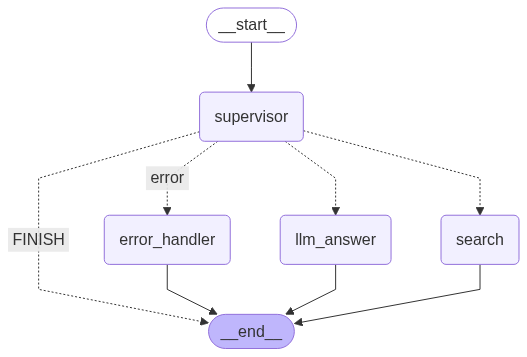

In [7]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import HumanMessage, AIMessage

inp = input("👤 You: ")
url = "https://github.com/"

user_msg = HumanMessage(content=inp)
state = ClausebitState(messages=[user_msg], current_url=url)

result = research_graph.invoke(state)

msgs = result.messages
last = [m for m in msgs if isinstance(m, AIMessage)]

print("🤖 ClauseBit:", last[-1].content if last else "(no response)")


[🧠 Supervisor received message]: Github cookie policy


/Users/mohammedansari/Desktop/clausebit/.venv/lib/python3.13/site-packages/google/cloud/firestore_v1/base_collection.py:304: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
Key 'additionalProperties' is not supported in schema, ignoring


[Supervisor routed to]: {'next': 'search'}
Using local credentials.


/Users/mohammedansari/Desktop/clausebit/.venv/lib/python3.13/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
Key 'additionalProperties' is not supported in schema, ignoring


AttributeError: 'dict' object has no attribute 'messages'

In [10]:
from typing import Annotated, List, Dict
from langchain_core.tools import tool
from sympy import false

from backend.src.tools.webscraper import ScraperManager
from backend.src.tools.vector_store import VectorStoreManager
from backend.src.tools.grader import Grader
from backend.src.tools.datatracker import get_company_by_url

import asyncio
import nest_asyncio

nest_asyncio.apply()


def fetch_web_data_to_db(url: str):
    vectorstore = VectorStoreManager()
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(vectorstore.proto_add_final(url))


@tool
def retrieve_and_grade(query, ispreferencedata=False, metadata=None) -> List[Dict]:
    """Retrieves chunks for a query and grades them for relevance, completeness, and faithfulness."""

    vectorstore = VectorStoreManager()
    grader = Grader()

    if ispreferencedata:
        retrieved_chunks = vectorstore.vectordb_query_filtering(query, metadata)
    else:
        retrieved_chunks = vectorstore.vectordb_query_chatbot(query)

    # Extract only the page_content to feed into the grader
    chunk_texts = [doc.page_content for doc in retrieved_chunks]

    # Grade the extracted texts
    grade_report = grader.CompositeGrader(chunk_texts, query)

    # merge the original document metadata into the report
    for i, score in enumerate(grade_report):
        score["metadata"] = retrieved_chunks[i].metadata
        score["document_id"] = retrieved_chunks[i].id

    return grade_report


@tool
def retriever(query: str, ispreferencedata: bool = False, metadata: Dict[str, str] = None) -> List[Dict]:
    """
    Retrieves the most relevant document chunks from the vector store based on the input query.

    This function supports both general-purpose semantic search and personalized retrieval using
    metadata filters. It is used to extract legal content (such as terms or policy sections)
    relevant to user questions from documents previously indexed in the vector database.

    Args:
        query (str): The user's natural language question or search phrase.
        ispreferencedata (bool, optional):
            If True, performs retrieval using user-defined preferences (e.g., data tracking = "false")
            by applying metadata filters. If False, performs standard similarity-based retrieval.
            Defaults to False.
        metadata (Dict[str, str], optional):
            Metadata constraints used during filtering (e.g., {"data_sharing": "false"}).
            Only applicable when `ispreferencedata` is True.

    Returns:
        List[Document]: A list of LangChain `Document` objects representing the most relevant
        chunks from stored content. Each document includes:
            - `id` (str): Unique document identifier (e.g., "doc_215")
            - `metadata` (dict): Metadata like the source URL
            - `page_content` (str): Extracted chunk of legal text relevant to the query
    """

    vectorstore = VectorStoreManager()

    if ispreferencedata:
        retrieved_chunks = vectorstore.vectordb_query_filtering(query, metadata)
    else:
        retrieved_chunks = vectorstore.vectordb_query_chatbot(query)

    return retrieved_chunks


def check_db(url: str):
    status = get_company_by_url(url)

    if not status:
        return False
    else:
        return status


from langgraph.graph import add_messages
from typing import Annotated
from langchain_core.messages import BaseMessage
from pydantic import BaseModel
from typing import List, Optional, Dict, Any


class ClausebitState(BaseModel):
    messages: Annotated[List[BaseMessage], add_messages]  # ✅ Correct + recommended
    user_preferences: Optional[Dict[str, Any]] = None
    scraped_chunks: Optional[List[str]] = None
    graded_clauses: Optional[List[Dict[str, Any]]] = None
    current_url: Optional[str] = None
    current_query: Optional[str] = None
    violations_found: Optional[List[Dict[str, Any]]] = None


from typing import List, Optional, Literal, TypedDict, Callable
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from backend.src.tools.datatracker import get_company_by_url  # Make sure this is correct
from langchain_core.messages import AIMessage


def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    options = ["FINISH"] + members

    def supervisor_node(state: ClausebitState) -> str:
        # ✅ Only continue if last message is from user
        if not isinstance(state.messages[-1], HumanMessage):
            return "FINISH"

        user_question = state.messages[-1].content.lower().strip()
        print("[🧠 Supervisor received message]:", state.messages[-1].content)

        # Check for conversational/meta questions that can be answered directly
        conversation_keywords = [
            "what was the last question", "what did i ask", "previous question",
            "last time", "before", "earlier", "conversation history"
        ]

        if any(keyword in user_question for keyword in conversation_keywords):
            return "llm_answer"

        # Check if current_url is provided for document-specific questions
        if not state.current_url:
            return "llm_answer"  # Route to LLM for general questions

        # Step 1: Check if the URL exists in the DB, if it does not trigger a scraping pipeline
        from backend.src.tools.datatracker import get_company_by_url
        db_status = get_company_by_url(state.current_url)

        if db_status == False:
            print(state.current_url)
            print("Scraping the web....")
            send_url = state.current_url
            print(send_url)
            fetch_web_data_to_db(state.current_url)
            db_status = get_company_by_url(state.current_url)

            if not db_status:
                return "error"

        # Step 2: If found_data is False → return gracefully
        if db_status and db_status.get("found_data") is False:
            return "error"

        # Step 3: Use LLM to decide whether to search again or finish
        system_prompt = (
            "You are a supervisor agent managing a conversation with access to two workers: `search` and `llm_answer`.\n\n"
            "• If the user asks about conversation history, previous questions, or general knowledge, route to `llm_answer`.\n"
            "• If the user asks something that requires information from a specific website's legal documents (e.g., Privacy Policy or Terms of Service), route to `search`.\n"
            "• If the user asks a general-purpose or factual question that can be answered by a language model, route to `llm_answer`.\n"
            "• Only return `FINISH` if the conversation should end naturally.\n"
            "• Always try to be helpful and route to an appropriate worker.\n"
        )

        class Router(TypedDict):
            next: Literal[*options]

        # Format messages properly for the LLM
        formatted_messages = []
        for msg in state.messages:
            if isinstance(msg, HumanMessage):
                formatted_messages.append({"role": "user", "content": msg.content})
            elif isinstance(msg, AIMessage):
                formatted_messages.append({"role": "assistant", "content": msg.content})

        messages = [{"role": "system", "content": system_prompt}] + formatted_messages
        response = llm.with_structured_output(Router).invoke(messages)
        print("[Supervisor routed to]:", response)

        goto = response["next"]
        if goto == "FINISH":
            return "FINISH"
        if goto not in members and goto != "FINISH":
            print(f"[⚠️ Invalid route '{goto}'], routing to llm_answer")
            return "llm_answer"

        return goto

    return supervisor_node


from langchain_google_vertexai import ChatVertexAI
from auth.init_vertex import init_vertex_ai
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

init_vertex_ai()

llm = ChatVertexAI(
    model="gemini-2.5-pro",
    temperature=0.5,
    max_output_tokens=3000
)

search_agent = create_react_agent(llm, tools=[retriever])


def search_node(state: ClausebitState) -> ClausebitState:
    """Search node that performs retrieval and returns results"""
    result = search_agent.invoke(state)

    # Add the search result as an AI message
    new_message = AIMessage(content=result["messages"][-1].content, name="search")

    # Return updated state
    return ClausebitState(
        messages=state.messages + [new_message],
        user_preferences=state.user_preferences,
        scraped_chunks=state.scraped_chunks,
        graded_clauses=state.graded_clauses,
        current_url=state.current_url,
        current_query=state.current_query,
        violations_found=state.violations_found
    )


def llm_answer_node(state: ClausebitState) -> ClausebitState:
    """LLM answer node for general questions and conversation history"""
    user_question = state.messages[-1].content.lower().strip()

    # Handle conversation history questions
    conversation_keywords = [
        "what was the last question", "what did i ask", "previous question",
        "last time", "before", "earlier", "conversation history"
    ]

    if any(keyword in user_question for keyword in conversation_keywords):
        # Find the previous user questions
        user_messages = [msg for msg in state.messages if isinstance(msg, HumanMessage)]
        if len(user_messages) >= 2:
            last_question = user_messages[-2].content  # -1 is current, -2 is previous
            response_content = f"Your last question was: \"{last_question}\""
        else:
            response_content = "This is your first question in our conversation."
    else:
        # Handle other general questions
        last_user_message = state.messages[-1].content

        # Create context from conversation history
        context = "Previous conversation:\n"
        for i, msg in enumerate(state.messages[:-1]):  # Exclude current message
            if isinstance(msg, HumanMessage):
                context += f"User: {msg.content}\n"
            elif isinstance(msg, AIMessage):
                context += f"Assistant: {msg.content}\n"

        # Add current question
        full_prompt = f"{context}\nCurrent question: {last_user_message}\n\nPlease provide a helpful response."

        llm_response = llm.invoke(full_prompt)
        response_content = llm_response.content

    new_message = AIMessage(content=response_content, name="llm_answer")

    # Return updated state
    return ClausebitState(
        messages=state.messages + [new_message],
        user_preferences=state.user_preferences,
        scraped_chunks=state.scraped_chunks,
        graded_clauses=state.graded_clauses,
        current_url=state.current_url,
        current_query=state.current_query,
        violations_found=state.violations_found
    )


def error_handler_node(state: ClausebitState) -> ClausebitState:
    """Handle errors and edge cases"""
    if not state.current_url:
        error_msg = AIMessage(content="❌ No URL provided. Cannot proceed.")
    else:
        # Check database status
        db_status = get_company_by_url(state.current_url)
        if db_status and db_status.get("found_data") is False:
            error_msg = AIMessage(
                content="⚠️ I can't answer questions for this company — no useful data was found during scraping.")
        else:
            error_msg = AIMessage(content="⚠️ An error occurred while processing your request.")

    # Return updated state
    return ClausebitState(
        messages=state.messages + [error_msg],
        user_preferences=state.user_preferences,
        scraped_chunks=state.scraped_chunks,
        graded_clauses=state.graded_clauses,
        current_url=state.current_url,
        current_query=state.current_query,
        violations_found=state.violations_found
    )


# Create supervisor node
research_supervisor_node = make_supervisor_node(llm, ["search", "llm_answer"])


# ✅ Fixed graph with conditional routing
def route_supervisor_decision(state: ClausebitState):
    """Route based on supervisor's decision"""
    decision = research_supervisor_node(state)
    return decision


# Build the graph
graph = StateGraph(ClausebitState)
graph.add_node("supervisor", lambda state: state)  # Supervisor just passes state through
graph.add_node("search", search_node)
graph.add_node("llm_answer", llm_answer_node)
graph.add_node("error_handler", error_handler_node)
graph.add_node("finish", lambda state: state)  # Finish node

# Set entry point
graph.set_entry_point("supervisor")

# ✅ Use conditional edges from supervisor
graph.add_conditional_edges(
    "supervisor",
    route_supervisor_decision,
    {
        "search": "search",
        "llm_answer": "llm_answer",
        "FINISH": "finish",
        "error": "error_handler"
    }
)

# ✅ All worker nodes go to END (no loops!)
graph.add_edge("search", END)
graph.add_edge("llm_answer", END)
graph.add_edge("error_handler", END)
graph.add_edge("finish", END)

research_graph = graph.compile()


Using local credentials.


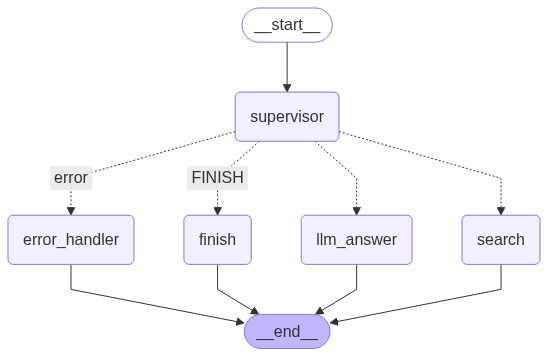

In [11]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Fast route for obvious document queries
        document_keywords = [
            "privacy policy", "terms of service", "cookies", "data collection",
            "user agreement", "legal", "policy", "terms", "privacy"
        ]

        if any(keyword in user_question for keyword in document_keywords) and state.current_url:
            # Quick DB check with cache
            db_status = get_cached_db_status(state.current_url)
            if db_status and db_status.get("found_data") is not False:
                return "search"

        # Check if current_url is provided for document-specific questions
        if not state.current_url:
            return "llm_answer"